## 1. Import Required Modules and Data

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV
)
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)
from sklearn.preprocessing import StandardScaler

In [2]:
# Set directory
path = 'C:/Users/cbrut/OneDrive/Documentos/GitHubStarPredictor'
os.chdir(path)

# Import data
git_data = pd.read_csv('data/github-repo-data-processed.csv')

## 2. Training Models

In [3]:
## Split the data into training and test sets
X = git_data.drop(['Stars'] , axis =1)
y = git_data['Stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
## Fit the scaler using only the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

## Transform the test set using the fitted scaler (do not refit)
X_test_scaled = scaler.transform(X_test)

In [5]:
## Initialize dictionaries to store the metrics for each model
metrics = {
    'Lasso': {},
    'Random Forest': {},
    'XGBoost': {}
}

### A. Lasso

In [6]:
## Define the parameter grid for Lasso
param_grid = {
    'alpha': np.logspace(-3, 3, num=7)  # Regularization strengths to test
}

## Initialize Lasso model
lasso_base = Lasso(max_iter=10000)  # Increase max_iter for better convergence

## Set up GridSearchCV with cross-validation
lasso_grid_search = GridSearchCV(
    estimator=lasso_base,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Optimizing for MSE
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all processors
    verbose=1  # Display progress
)

## Fit GridSearchCV to training data
lasso_grid_search.fit(X_train_scaled, y_train)

## Best parameters and best model
best_lasso_params = lasso_grid_search.best_params_
best_lasso_model = lasso_grid_search.best_estimator_

## Training predictions and metrics
y_train_pred_lasso = best_lasso_model.predict(X_train_scaled)
metrics['Lasso']['MSE_train'] = mean_squared_error(y_train, y_train_pred_lasso, squared=False)
metrics['Lasso']['MAE_train'] = mean_absolute_error(y_train, y_train_pred_lasso)
metrics['Lasso']['R2_train'] = r2_score(y_train, y_train_pred_lasso)

## Test predictions and metrics
y_test_pred_lasso = best_lasso_model.predict(X_test_scaled)
metrics['Lasso']['MSE_test'] = mean_squared_error(y_test, y_test_pred_lasso, squared=False)
metrics['Lasso']['MAE_test'] = mean_absolute_error(y_test, y_test_pred_lasso)
metrics['Lasso']['R2_test'] = r2_score(y_test, y_test_pred_lasso)

## Extracting the most important features for Lasso
lasso_coefficients = pd.Series(best_lasso_model.coef_, index=X_train.columns)
lasso_top_features = lasso_coefficients.abs().sort_values(ascending=False).head(5)

## Print Lasso metrics and important features
print("\n")
print("Lasso Model Metrics:")
print("\n")
print(f"  Best Parameters: {best_lasso_params}")
print(f"  Best Lasso Model: {best_lasso_model}")
print("\n")
print(f"  Training MSE: {metrics['Lasso']['MSE_train']}")
print(f"  Training MAE: {metrics['Lasso']['MAE_train']}")
print(f"  Training R2: {metrics['Lasso']['R2_train']}")
print("\n")
print(f"  Test MSE: {metrics['Lasso']['MSE_test']}")
print(f"  Test MAE: {metrics['Lasso']['MAE_test']}")
print(f"  Test R2: {metrics['Lasso']['R2_test']}")
print("\n")
print("  Top 5 important features (Lasso Coefficients):")
print(lasso_top_features)
print("\n")

Fitting 5 folds for each of 7 candidates, totalling 35 fits


Lasso Model Metrics:


  Best Parameters: {'alpha': 0.001}
  Best Lasso Model: Lasso(alpha=0.001, max_iter=10000)


  Training MSE: 0.6539286988708383
  Training MAE: 0.5077571046300701
  Training R2: 0.561963761768562


  Test MSE: 0.6530090269611547
  Test MAE: 0.5074353227578603
  Test R2: 0.5576486948023585


  Top 5 important features (Lasso Coefficients):
Forks               0.658838
Issues              0.113705
Last Update         0.078343
Has Discussions     0.067631
Language Unknown    0.053899
dtype: float64




### B. Random Forest

In [7]:
## Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50],  # Reasonable number of trees for balanced performance and computation time
    'max_depth': [5, 10],  # Limiting tree depth to prevent overfitting
    'min_samples_split': [2, 5, 10],  # Avoiding splits with too few samples
    'min_samples_leaf': [1, 2, 5],  # Minimum number of samples per leaf node to generalize better
    'max_features': [0.3, 0.5],  # Reduce features used for a good trade-off in feature selection
    'bootstrap': [True]  # Bootstrap to improve generalization
}

  
## Initialize Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

## Set up GridSearchCV with cross-validation
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Optimizing for MSE
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all processors
    verbose=2  # Display progress
)

## Fit GridSearchCV to training data
grid_search_rf.fit(X_train_scaled, y_train)

## Best parameters and best model
best_params_rf = grid_search_rf.best_params_
best_rf_model = grid_search_rf.best_estimator_

## Training predictions and metrics
y_train_pred_rf = best_rf_model.predict(X_train_scaled)
metrics['Random Forest']['MSE_train'] = mean_squared_error(y_train, y_train_pred_rf, squared=False)
metrics['Random Forest']['MAE_train'] = mean_absolute_error(y_train, y_train_pred_rf)
metrics['Random Forest']['R2_train'] = r2_score(y_train, y_train_pred_rf)

## Test predictions and metrics
y_test_pred_rf = best_rf_model.predict(X_test_scaled)
metrics['Random Forest']['MSE_test'] = mean_squared_error(y_test, y_test_pred_rf, squared=False)
metrics['Random Forest']['MAE_test'] = mean_absolute_error(y_test, y_test_pred_rf)
metrics['Random Forest']['R2_test'] = r2_score(y_test, y_test_pred_rf)

# Identify the top 5 most important features
feature_names = X_train.columns
importances_rf = best_rf_model.feature_importances_
important_features_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_rf
})
top_5_features_rf = important_features_rf.sort_values(by='Importance', ascending=False).head(5)

## Print Random Forest metrics and important features
print("\n")
print("Random Forest Model Metrics:")
print("\n")
print(f"  Best Parameters: {best_params_rf}")
print(f"  Best Random Forest Model: {best_rf_model}")
print("\n")
print(f"  Training MSE: {metrics['Random Forest']['MSE_train']}")
print(f"  Training MAE: {metrics['Random Forest']['MAE_train']}")
print(f"  Training R2: {metrics['Random Forest']['R2_train']}")
print("\n")
print(f"  Test MSE: {metrics['Random Forest']['MSE_test']}")
print(f"  Test MAE: {metrics['Random Forest']['MAE_test']}")
print(f"  Test R2: {metrics['Random Forest']['R2_test']}")
print("\n")
print("  Top 5 important features (Random Forest):")
print(top_5_features_rf)
print("\n")

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Random Forest Model Metrics:


  Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
  Best Random Forest Model: RandomForestRegressor(max_depth=10, max_features=0.5, min_samples_split=5,
                      n_estimators=50, n_jobs=-1, random_state=42)


  Training MSE: 0.5132433647780328
  Training MAE: 0.400311940013849
  Training R2: 0.7301664590699952


  Test MSE: 0.5545178651572873
  Test MAE: 0.4279959427961963
  Test R2: 0.6810225157384753


  Top 5 important features (Random Forest):
        Feature  Importance
2         Forks    0.702999
13  Last Update    0.141423
3        Issues    0.077144
12          Age    0.019265
1          Size    0.011383




### C. XGBoost

In [8]:
## Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50],  # Reasonable number of trees for balanced performance and computation time
    'max_depth': [5, 10],  # Limiting tree depth to prevent overfitting
    'learning_rate': [0.01, 0.1], # Boosting learning rate
    'subsample': [0.6, 0.8, 1], # Subsample ratio of the training instance
    'colsample_bytree': [0.3, 0.5], # Subsample ratio of columns when constructing each tree
    'gamma': [0.1, 0.2] # Minimum loss reduction required to make a further partition on a leaf node of the tree
}

  
## Initialize XGBoost model
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)

## Set up GridSearchCV with cross-validation
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Optimizing for MSE
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all processors
    verbose=2  # Display progress
)

## Fit GridSearchCV to training data
grid_search_xgb.fit(X_train_scaled, y_train)

## Best parameters and best model
best_xgb_params = grid_search_xgb.best_params_
best_xgb_model = grid_search_xgb.best_estimator_

## Training predictions and metrics
y_train_pred_xgb = best_xgb_model.predict(X_train_scaled)
metrics['XGBoost']['MSE_train'] = mean_squared_error(y_train, y_train_pred_xgb, squared=False)
metrics['XGBoost']['MAE_train'] = mean_absolute_error(y_train, y_train_pred_xgb)
metrics['XGBoost']['R2_train'] = r2_score(y_train, y_train_pred_xgb)

## Test predictions and metrics
y_test_pred_xgb = best_xgb_model.predict(X_test_scaled)
metrics['XGBoost']['MSE_test'] = mean_squared_error(y_test, y_test_pred_xgb, squared=False)
metrics['XGBoost']['MAE_test'] = mean_absolute_error(y_test, y_test_pred_xgb)
metrics['XGBoost']['R2_test'] = r2_score(y_test, y_test_pred_xgb)

# Identify the top 5 most important features
feature_names = X_train.columns  
importances_xgb = best_xgb_model.feature_importances_
important_features_xgb = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_xgb
})
top_5_features_xgb = important_features_xgb.sort_values(by='Importance', ascending=False).head(5)

# Imprimir métricas y características importantes
print("\n")
print("XGBoost Model Metrics:")
print("\n")
print(f"  Best Parameters: {best_xgb_params}")
print(f"  Best XGBoost Model: {best_xgb_model}")
print("\n")
print(f"  Training MSE: {metrics['XGBoost']['MSE_train']}")
print(f"  Training MAE: {metrics['XGBoost']['MAE_train']}")
print(f"  Training R2: {metrics['XGBoost']['R2_train']}")
print("\n")
print(f"  Test MSE: {metrics['XGBoost']['MSE_test']}")
print(f"  Test MAE: {metrics['XGBoost']['MAE_test']}")
print(f"  Test R2: {metrics['XGBoost']['R2_test']}")
print("\n")
print("  Top 5 important features (XGBoost):")
print(top_5_features_xgb)
print("\n")


Fitting 5 folds for each of 48 candidates, totalling 240 fits


XGBoost Model Metrics:


  Best Parameters: {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'subsample': 1}
  Best XGBoost Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)


  Training MSE: 0

## 3. Model Comparison

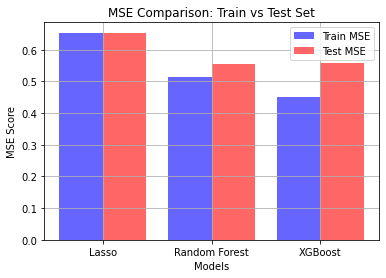

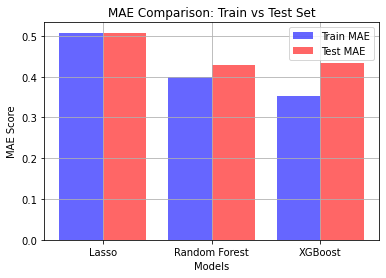

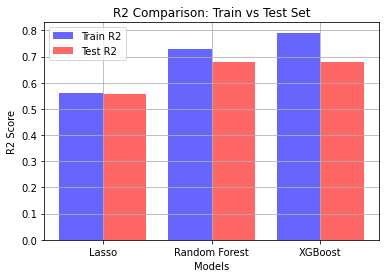

In [9]:
## Bar Plots: MSE, MAE and R-Squared scores for each model (train and test)
models = ['Lasso', 'Random Forest', 'XGBoost']
metrics_dict = ['MSE', 'MAE', 'R2']

for metric in metrics_dict:
    metric_train = [metrics[model][f'{metric}_train'] for model in models]
    metric_test = [metrics[model][f'{metric}_test'] for model in models]

    # Plot
    plt.bar(np.arange(len(models)) - 0.2, metric_train, 0.4, label=f'Train {metric}', color='b', alpha=0.6)
    plt.bar(np.arange(len(models)) + 0.2, metric_test, 0.4, label=f'Test {metric}', color='r', alpha=0.6)
    plt.xticks(np.arange(len(models)), models)
    plt.xlabel('Models')
    plt.ylabel(f'{metric} Score')
    plt.title(f'{metric} Comparison: Train vs Test Set')
    plt.legend()
    plt.grid(True)      
    plt.show()

In [10]:
## Find the model with the minimum MSE
best_model = min(metrics, key=lambda model: metrics[model]['MSE_test'])
print(f"The model with the minimum MSE is: {best_model}")

The model with the minimum MSE is: Random Forest


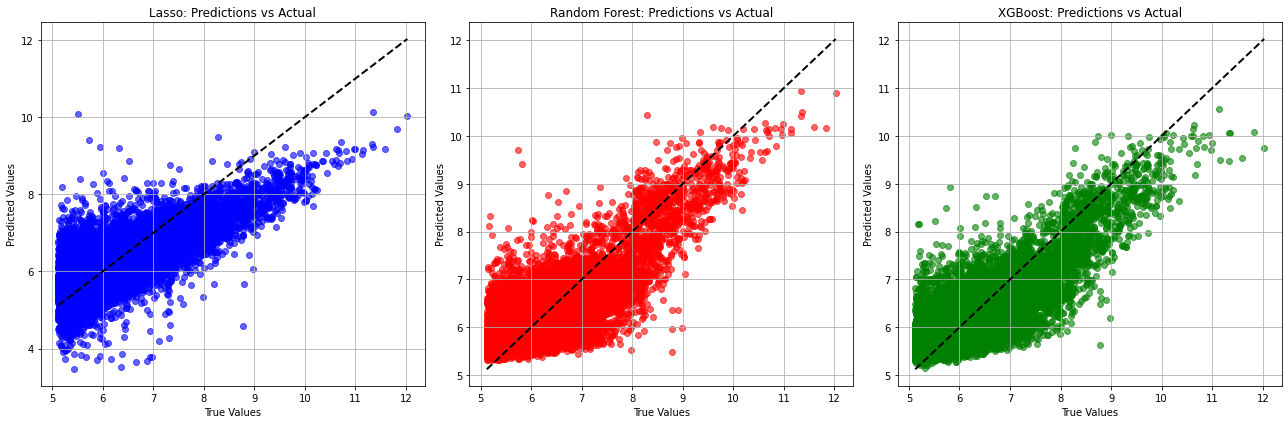

In [11]:
## Scatter Plots: Predictions vs Actual

# Create a figure with three subplots (side by side)
plt.figure(figsize=(18, 6))

# Scatter plot for Lasso
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_test_pred_lasso, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Lasso: Predictions vs Actual')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)

# Scatter plot for Random Forest
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_test_pred_rf, color='red', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Random Forest: Predictions vs Actual')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)

# Scatter plot for XGBoost
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_test_pred_xgb, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('XGBoost: Predictions vs Actual')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)

# Adjust spacing between the subplots
plt.tight_layout()
plt.show()
